In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

NB_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(NB_DIR)
sys.path.append(ROOT_DIR)

from cosas.data_model import ScannerData, COSASData
from cosas.paths import DATA_DIR

cosas_data = COSASData(os.path.join(DATA_DIR, "task2"))
cosas_data.load()

COSASData(
  data_dir=/vast/AI_team/dataset/COSAS24-TrainingSet/task2,
  kfbio=ScannerData(data_dir=/vast/AI_team/dataset/COSAS24-TrainingSet/task2/kfbio-400, N images=60, N mask=60
  ddd=ScannerData(data_dir=/vast/AI_team/dataset/COSAS24-TrainingSet/task2/3d-1000, N images=60, N mask=60
  teksqray=ScannerData(data_dir=/vast/AI_team/dataset/COSAS24-TrainingSet/task2/teksqray-600p, N images=60, N mask=60
  image(n=180)
)

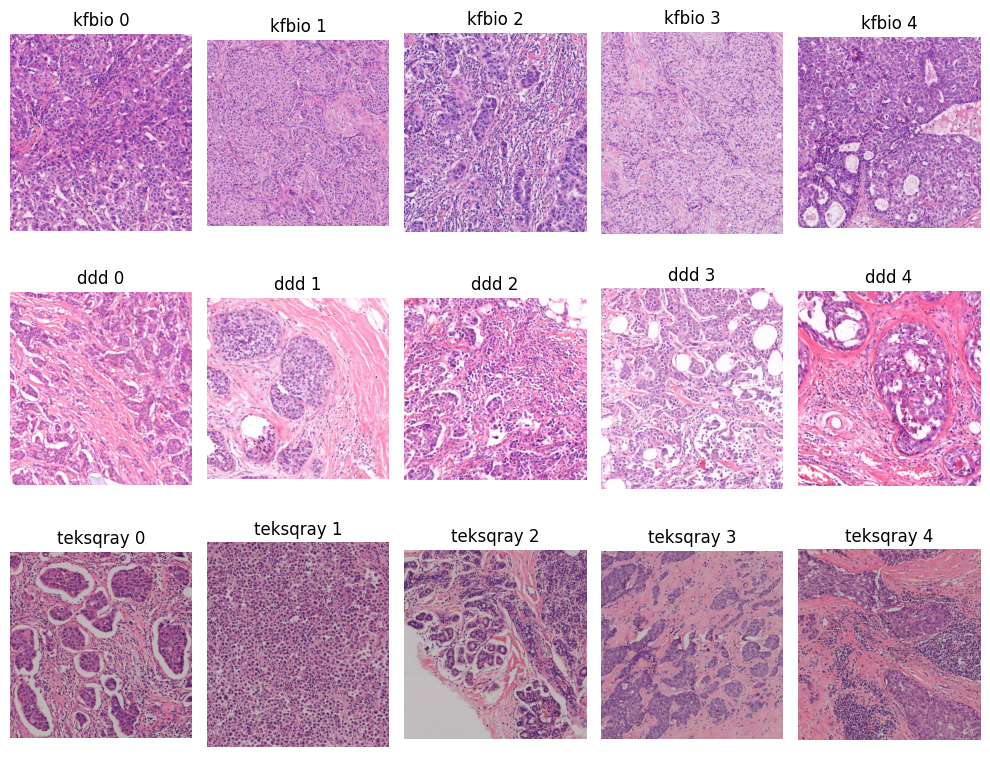

In [3]:
import random
from matplotlib import pyplot as plt
from cosas.data_model import Scanncers

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 8))
for scanner_idx, scanner in enumerate(Scanncers):
    scanner_data: ScannerData = getattr(cosas_data, scanner.name)
    images = random.sample(scanner_data.images, k=5)
    for image_idx, image in enumerate(images):
        ax = axes[scanner_idx, image_idx]
        ax.imshow(image)
        ax.set_title(f"{scanner.name} {image_idx}")
        ax.axis("off")

plt.tight_layout()
plt.show()

#### Color distribution: RGB

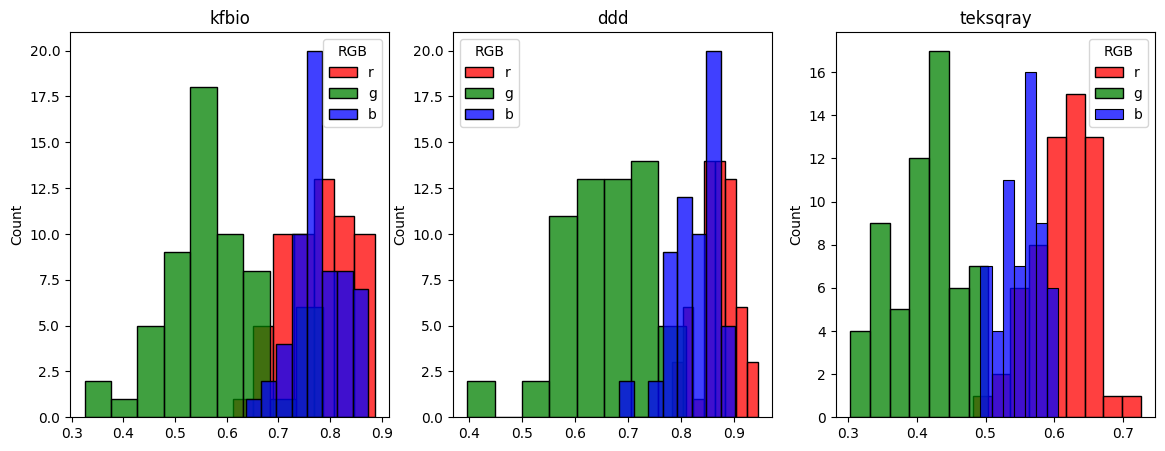

In [4]:
import colorsys
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from skimage.color import rgb2lab

def get_color_value(dataset:ScannerData, space_name=str):
    spaces = {"hsv":colorsys.rgb_to_hsv, "lab":rgb2lab, "rgb": lambda x: x}
    
    colors = np.zeros((len(dataset), 3), dtype=np.float32)
    for i, image_array in enumerate(dataset.images):
        mean_rgb = image_array.mean(axis=0).mean(axis=0)/255
        if space_name == "hsv":
            colors[i] = spaces[space_name](*mean_rgb)
        else:
            colors[i] = spaces[space_name](mean_rgb)
        
    return colors


fig, axes = plt.subplots(1, 3, figsize=(14, 5))
for i, scanner in enumerate(Scanncers):
    rgbs = get_color_value(getattr(cosas_data, scanner.name), space_name="rgb")
    for j, color in enumerate(['r', 'g', 'b']):
        sns.histplot(rgbs[:, j], ax=axes[i], color=color, label=color)
        axes[i].set_title(scanner.name)
    
    axes[i].legend(title='RGB')

HSV color space: value값 매우 낮음 (TESKQRAY)

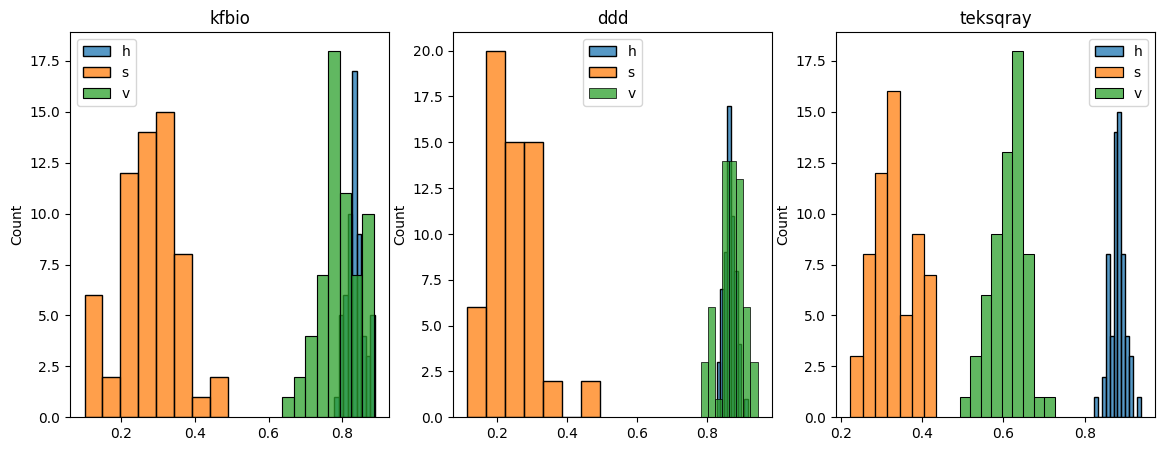

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
for i, scanner in enumerate(Scanncers):
    hsv = get_color_value(getattr(cosas_data, scanner.name), space_name="hsv")
    for j, color in enumerate(['h', 's', 'v']):
        sns.histplot(hsv[:, j], ax=axes[i], label=color)
        axes[i].set_title(scanner.name)
        
    axes[i].legend()

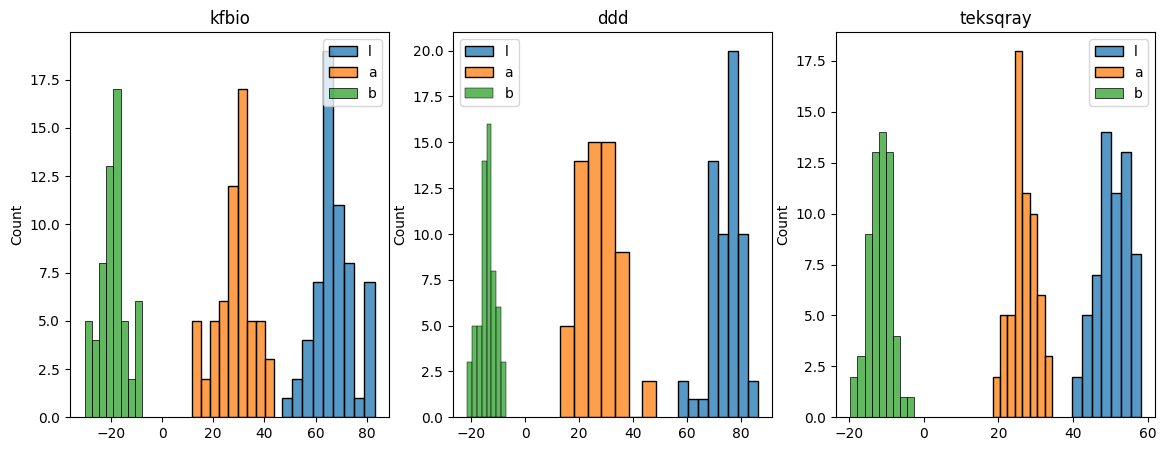

In [6]:
# TEKSQRAY에서 L값이 20정도 낮음. 
# HSV에 비교해서는 LAB 컬러로 변환하는게 더 이산적인듯.. (LAB은 각 채널이 원래 독립적이긴함.)
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
for i, scanner in enumerate(Scanncers):
    hsv = get_color_value(getattr(cosas_data, scanner.name), space_name="lab")
    for j, color in enumerate(['l', 'a', 'b']):
        sns.histplot(hsv[:, j], ax=axes[i], label=color)
        axes[i].set_title(scanner.name)
        
    axes[i].legend()

Example image and mask

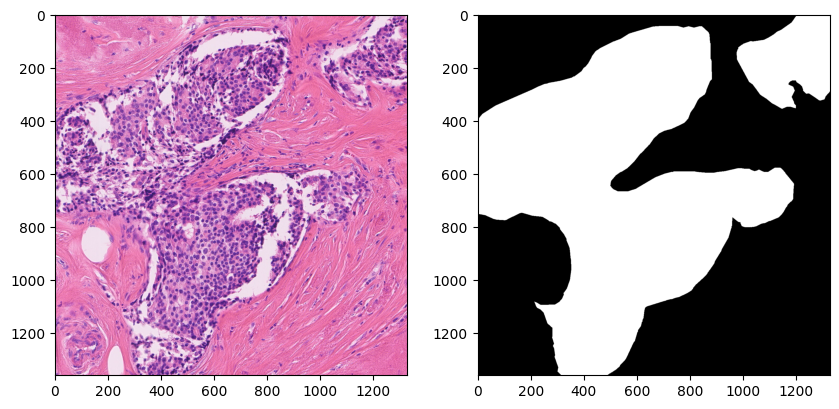

In [52]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cosas_data.kfbio.images[0])
axes[1].imshow(cosas_data.kfbio.masks[0], cmap="gray")

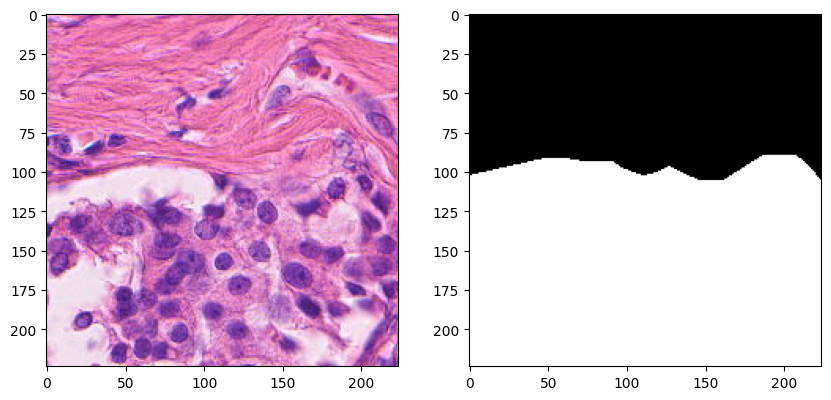

In [53]:
import albumentations as A

transform = A.Compose(
    [
        A.RandomCrop(height=224, width=224, p=1),
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]    
)
augmented_xy = transform(image=cosas_data.kfbio.images[0], mask=cosas_data.kfbio.masks[0])

from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(augmented_xy["image"])
axes[1].imshow(augmented_xy["mask"], cmap="gray")